In [ ]:
!pip install num2words
# !pip install word2number

     |████████████████████████████████| 102kB 3.3MB/s 


In [ ]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer
# from keras.layers import Bidirectional,LSTM,Dense,Embedding,Dropout,Activation,Input,BatchNormalization,GlobalAveragePooling1D,Flatten
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import gensim
import numpy as np
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# from tensorflow.keras.models import Model,load_model
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam,SGD,Adadelta,RMSprop
# from keras.layers import Layer,Dense,concatenate,Lambda,Add,dot
# from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from num2words import num2words 
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.layers import LayerNormalization,Bidirectional,LSTM,Dense,Embedding,Dropout,Activation,Input,BatchNormalization,GlobalAveragePooling1D,Flatten,Layer,concatenate,Lambda,Add,dot,MaxPooling1D,Conv1D,Multiply,GRU
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import KeyedVectors
from tensorflow.keras import Sequential 
from tensorflow.keras.regularizers import l2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# ! unzip -q -n  /content/drive/My\ Drive/fake\ news/crawl-300d-2M.vec.zip -d /content
# ! unzip -q -n  /content/drive/My\ Drive/fake\ news/wiki-news-300d-1M.vec.zip -d /content

In [ ]:
# df_train_bodies=pd.read_csv('/content/train_bodies.csv')
# df_train_stances=pd.read_csv('/content/train_stances.csv')
# p2si_train=pd.read_csv('/content/paragraph2sentence.train.input.tsv',sep='\t',names=['para','sent','id'])
# p2so_train=pd.read_csv('/content/paragraph2sentence.train.gs.tsv',sep='\t',names=['score'])
# df_train_bodies.head(5)
# df=pd.read_excel('/content/text_similarity.xlsx')
# df_train=pd.read_csv('/content/df_train.csv')
df_test=pd.read_csv('/content/df_test.csv')
# test=pd.read_csv('/content/drive/My Drive/fake news/test.csv')

In [ ]:
df_train=df_train.dropna()
df_train.isnull().values.sum()

0

In [ ]:
def preprocessing(text):
  text=str(text)
  # pattern='https?:\S+|[^a-zA-Z0-9]+'
  # text=re.sub(pattern,' ',text.lower()).strip()
  # tokens=[]
  # for token in text.split():
  #   try:
  #     token=num2words(token)
  #   except:
  #     pass
  #   # if token not in stop_words:
  #   tokens.append(lemmatizer.lemmatize(token))
  #   # tokens.append(token)
  #   # tokens.append(stemmer.stem(token))
  # return " ".join(tokens)
  return text.lower()

nltk.download('stopwords')
stop_words=stopwords.words('english')
stemmer=SnowballStemmer('english')
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
test.question1=test.question1.apply(preprocessing)
test.question2=test.question2.apply(preprocessing)

In [ ]:
word2vec = KeyedVectors.load_word2vec_format('/content/drive/My Drive/fake news/GoogleNews-vectors-negative300.bin', binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
# word2vec.vocab

In [ ]:
# language=list(df_train.articleBody)+list(df_train.Headline)
language=list(df_train.question1)+list(df_train.question2)
tokenizer=Tokenizer()
tokenizer.fit_on_texts(language)


In [ ]:
X_train_article=pad_sequences(tokenizer.texts_to_sequences(df_train.question1),maxlen=30)
X_test_article=pad_sequences(tokenizer.texts_to_sequences(df_test.question1),maxlen=30)

In [ ]:
X_train_article.shape

(388496, 30)

In [ ]:
X_train_head=pad_sequences(tokenizer.texts_to_sequences(df_train.question2),maxlen=30)
X_test_head=pad_sequences(tokenizer.texts_to_sequences(df_test.question2),maxlen=30)

In [ ]:
X_train_head.shape

(388496, 30)

In [ ]:
# y_train=df_train.is_duplicate
y_test=df_test.is_duplicate

In [ ]:
# encoder=LabelEncoder()
# y_train=encoder.fit_transform(df_train.Stance)
# y_test=encoder.transform(df_test.Stance)
# y_train=to_categorical(y_train, num_classes=2)
y_test=to_categorical(y_test, num_classes=2)

In [ ]:
y_train

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       ...,
       [0., 1.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [ ]:
vocab_size=len(tokenizer.word_index)+1
embedding_matrix=np.zeros((vocab_size,300))
for word,i in tokenizer.word_index.items():
    if word in word2vec.vocab:
        embedding_matrix[i]=word2vec.word_vec(word)

In [ ]:
def f1_m(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    # tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)


def precision(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    # tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    return p

def recall(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    # tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)
    r = tp / (tp + fn + K.epsilon())
    return r



In [ ]:
class MultiHeadAttention(Layer):
  def __init__(self,embdim,nheads):
    super(MultiHeadAttention,self).__init__()
    self.embdim=embdim
    self.nheads=nheads
    self.wq=Dense(embdim)
    self.wk=Dense(embdim)
    self.wv=Dense(embdim)
    self.out_dense=Dense(embdim)
    self.depth=embdim//nheads
 
  def split_heads(self,x,batch_size):
    x=tf.reshape(x,(batch_size,-1,self.nheads,self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])
 
  def scaled_dot_attention(self,q,k,v):
    # k=(tf.math.square(k))
    # q=(tf.math.square(q))
    qk=tf.matmul(q,k,transpose_b=True)
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_qk=qk/tf.math.sqrt(dk)
    attention_weights=tf.nn.softmax(scaled_qk,axis=-1)
    output=tf.matmul(attention_weights,v)
    return output,attention_weights


 
  def call(self,inputs):
    q=self.wq(inputs)
    v=self.wv(inputs)
    k=self.wk(inputs)
    batch_size=tf.shape(inputs)[0]
    q=self.split_heads(q,batch_size)
    k=self.split_heads(k,batch_size)
    v=self.split_heads(v,batch_size)
    
    scaled_attention,weights=self.scaled_dot_attention(q,k,v)
    scaled_attention= tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
    concat_attention=tf.reshape(scaled_attention,(batch_size,-1,self.embdim))
    output=self.out_dense(concat_attention)
    return output
 
class PositionalEncoding(Layer):
  def __init__(self, d_model):
    super(PositionalEncoding,self).__init__()
    self.d_model = d_model
 
  def call(self, inputs):
    position = tf.shape(inputs)[1]
 
    position_dims = tf.range(position)[:, tf.newaxis]
    embed_dims = tf.range(self.d_model)[tf.newaxis, :]
    angle_rates = 1 / tf.pow(
        10000.0, tf.cast(
            (2 * (embed_dims // 2)) / self.d_model, tf.float32))
    angle_rads = tf.cast(position_dims, tf.float32) * angle_rates
 
    sines = tf.sin(angle_rads[:, 0::2])
    cosines = tf.cos(angle_rads[:, 1::2]) 
    pos_encoding = tf.concat([sines, cosines], axis=-1)
    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)
 
 
 
class Transformer(Layer):
  def __init__(self,embdim,nheads,dff,rate):
    super(Transformer,self).__init__()
    self.ffn1=Dense(dff, activation='relu')
    self.ffn3=Dense(dff/2,activation='relu')
    self.ffn4=Dense(dff/4,activation='relu')
    self.ffn2=Dense(embdim)
    self.mha=MultiHeadAttention(embdim,nheads)
    self.layernorm1 = LayerNormalization(epsilon=1e-6)
    self.layernorm2 = LayerNormalization(epsilon=1e-6)
    self.dropout1 = Dropout(rate)
    self.dropout2 = Dropout(rate)
    self.dropout3 = Dropout(rate)
    self.dropout4 = Dropout(rate)
    
 
  def call(self,inputs):
    att_out=self.mha(inputs)
    att_out=self.dropout1(att_out)
    out1=self.layernorm1(inputs+att_out)
    ff=self.ffn1(out1)
    ff=self.ffn2(ff)
    ff=self.dropout2(ff)
    return self.layernorm2(out1+ff)
 
 
class AvgWords(Layer):
  def __init__(self,output_dim):
    super(AvgWords,self).__init__()
    self.output_dim=output_dim
 
  def call(self, inputs):
    axis = K.ndim(inputs) - 2
    input_shape = K.shape(inputs)
    bs = input_shape[0]
    summed=tf.reduce_sum(inputs,axis=axis)
    nwords=tf.math.reduce_sum(tf.cast(tf.math.greater(tf.math.reduce_sum(tf.cast(tf.math.not_equal(inputs, 0),dtype='int16'),axis=axis+1),0),dtype='float32'),axis=-1)
    return summed/tf.reshape(nwords,shape=(bs,1))
    # return K.mean(inputs, axis=axis)
    # x=summed/tf.reshape(nwords,shape=(bs,1))
    # return tf.concat([x,tf.reshape(nwords,shape=(bs,1))],1)
 
  def compute_output_shape(self,input_shape):
    return (input_shape[0], self.output_dim)
 
 
class WordDropout(Layer):
  def __init__(self,rate):
    super(WordDropout,self).__init__()
    self.rate=rate
  
  def call(self,inputs):
    input_shape = K.shape(inputs)
    batch_size = input_shape[0]
    words = input_shape[1]
    mask = K.random_uniform((batch_size, words, 1)) >= self.rate
    w_drop = K.cast(mask, 'float32') * inputs
    return w_drop

Transformer model

In [ ]:
embedding_layer_head=Embedding(vocab_size,300,weights=[embedding_matrix],input_length=X_train_head.shape[1],trainable=False)
embedding_layer_article=Embedding(vocab_size,300,weights=[embedding_matrix],input_length=X_train_article.shape[1],trainable=False)
# embedding_layer_c=Embedding(vocab_size_c+1,70,weights=[embedding_weights],input_length=X_train_article_c.shape[1],trainable=True)
 


convdim=128
conv_layers=[[convdim,3,1],
            [convdim,3,1],
            # [convdim,5,1],
            # [convdim,5,1],
            # [convdim,5,1],
            #  [convdim,5,1]
 
            # [256,3,-1],
            # [300,3,3]
             ]
   
embdim=300
concdim=embdim+convdim
nheads=10
dff=512
n_hidden = 50
rate=0.2
depth=3
# shared_lstm = LSTM(n_hidden)
reg=l2(l=1e-3)

transform=Transformer(embdim,nheads,dff,rate)

X_input_article=Input(shape=(X_train_article.shape[1],))
X1=embedding_layer_article(X_input_article)
# X1=Lambda(function=lambda x: x*tf.math.sqrt(tf.cast(embdim, tf.float32)))(X1)
# X1 *= tf.math.sqrt(tf.cast(embdim, tf.float32))
# pos=PositionalEncoding(300)(X1)
# X1=Add()([X1,pos])
# X1=WordDropout(0.1)(X1)
 
 
# X_input_article_c=Input(shape=(X_train_article_c.shape[1],))
# X=embedding_layer_c(X_input_article_c)
# # print(X.shape)
# for filter_num,filter_size,strides in conv_layers:
#   # X1=BatchNormalization()(X)
#   X1=Conv1D(filter_num,filter_size,activation='relu',padding='same',strides=strides)(X1)
#   X1=Dropout(rate)(X1)
 
#   # if pooling_size!=-1:
#   #   X=MaxPooling1D(pool_size=pooling_size,padding='same')(X)
# # X= GRU(300, return_sequences=True)(X)
# # X= GRU(100, return_sequences=True)(X)
 
# X1=concatenate([X1,X],axis=-1)
# print(X1.shape)
# X1=Dropout(rate)(X1)
# X1=BatchNormalization()(X1)
 
# tgate=Dense(X1.shape[-1])(X1)
# cgate=Lambda(lambda x: 1.-x)(tgate)
# z=Dense(X1.shape[-1],activation='relu')(X1)
# t_z=Multiply()([tgate,z])
# c_z=Multiply()([cgate,X1])
# X1=Add()([t_z,c_z])

print(X1.shape)
for i in range(depth):
  # X1=BatchNormalization()(X1)
  # X1=Dropout(rate)(X1)
  X1=transform(X1)
  X1=BatchNormalization()(X1)
# X1 = shared_lstm(X1)
# X1=AvgWords(embdim)(X1)

# for filter_num,filter_size,strides in conv_layers:
#   X=BatchNormalization()(X)
#   X=Conv1D(filter_num,filter_size,activation='relu',padding='valid',strides=strides)(X)
#   X=Dropout(rate)(X)
 

X1=Flatten()(X1)
# X1=GlobalAveragePooling1D()(X1)
# X1=Dense(300,activation='relu')(X1)
# X1=BatchNormalization()(X1)
# X1=Dropout(rate)(X1)
 
X_input_head=Input(shape=(X_train_head.shape[1],))
X2=embedding_layer_head(X_input_head)
# X2 *= tf.math.sqrt(tf.cast(embdim, tf.float32))
# X2=Lambda(function=lambda x: x*tf.math.sqrt(tf.cast(embdim, tf.float32)))(X2)
# pos=PositionalEncoding(300)(X2)
# X2=Add()([X2,pos])
# X2=WordDropout(0.1)(X2)
# X_input_head_c=Input(shape=(X_train_head_c.shape[1],))
# X=embedding_layer_c(X_input_head_c)
 
# for filter_num,filter_size,strides in conv_layers:
#   # X=BatchNormalization()(X)
#   X2=Conv1D(filter_num,filter_size,activation='relu',padding='same',strides=strides)(X2)
#   X2=Dropout(rate)(X2) 
#   # if pooling_size!=-1:
#   #   X=MaxPooling1D(pool_size=pooling_size,padding='same')(X)

# # X= GRU(300, return_sequences=True)(X)
# # X= GRU(100, return_sequences=True)(X)
# X2=concatenate([X2,X],axis=-1)
# X2=Dropout(rate)(X2)
# X2=BatchNormalization()(X2)
# tgate=Dense(X2.shape[-1])(X2)
# cgate=Lambda(lambda x: 1-x)(tgate)
# z=Dense(X2.shape[-1],activation='relu')(X2)
# c_z=Multiply()([cgate,X2])
# t_z=Multiply()([tgate,z])
# X2=Add()([t_z,c_z])

for i in range(depth):
  # X2=BatchNormalization()(X2)
  # X2=Dropout(rate)(X2)
  X2=transform(X2)
  X2=BatchNormalization()(X2)
 

# for filter_num,filter_size,strides in conv_layers:
#   X=BatchNormalization()(X)
#   X=Conv1D(filter_num,filter_size,activation='relu',padding='valid',strides=strides)(X)
#   X=Dropout(rate)(X)
 
# X2 = shared_lstm(X2)
# X2=AvgWords(embdim)(X2)
X2=Flatten()(X2)
# X2=Dense(300,activation='relu')(X2)
# X2=BatchNormalization()(X2)
# X2=Dropout(rate)(X2)
 
 
X=concatenate([X1,X2])
X=BatchNormalization()(X)                                                                                                           
X=Dense(512,activation='relu',kernel_regularizer=reg)(X)
# # X=BatchNormalization()(X)
X=Dropout(rate)(X)
# # X=Dense(384,activation='relu')(X)
X=Dense(256,activation='relu',kernel_regularizer=reg)(X)
# # X=BatchNormalization()(X)
X=Dropout(rate)(X)
# # X=Dense(192,activation='relu')(X)
X=Dense(128,activation='relu',kernel_regularizer=reg)(X)
# # X=BatchNormalization()(X)
X=Dropout(rate)(X)
# # X=Dense(96,activation='relu')(X)
X=Dense(64,activation='relu',kernel_regularizer=reg)(X)
# X=BatchNormalization()(X)
# X=Dropout(rate)(X)
# X=Dense(48,activation='relu')(X)
# X=Dense(32,activation='relu')(X)
# X=BatchNormalization()(X)
# X=Dropout(rate)(X)
# X=Dense(16,activation='relu')(X)
 
# out=Dense(1,activation='sigmoid')(X)
# X2=GlobalAveragePooling1D()(X2)
# shared_lstm = LSTM(n_hidden)
 
# X2 = shared_lstm(X2)
# X1 = shared_lstm(X1)
 
# X=dot([X1,X2],axes=1)
# out = Lambda(function=lambda x: exponent_neg_manhattan_distance(x[0], x[1]),output_shape=lambda x: (x[0][0], 1))([X2, X1])
out=Dense(2,activation='softmax')(X)
# out=Dense(1,activation='softmax')(X)
# model=Model(inputs=[X_input_article,X_input_article_c,X_input_head,X_input_head_c],outputs=out)
model=Model(inputs=[X_input_article,X_input_head], outputs=out)
# model=Model(inputs=[X_input_article_c,X_input_head_c], outputs=out)
 
model.summary()

(None, 30, 300)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 30, 300)      22427700    input_3[0][0]                    
__________________________________________________________________________________________________
transformer_1 (Transformer)     (None, 30, 300)      670412      embedding_3[0][0]                
                                                                 batch_normalization_3[0][0]      
                                                                 batch_normalization_4[0][0]      
                                                                 embedding_2

In [ ]:
bs=1024
lr_decay = (1./0.9 -1)/bs
# opt = Adam(lr=(1e-4),beta_1=0.9,beta_2=0.999)
opt=RMSprop(learning_rate=1e-4)
loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2)

# opt=SGD(lr=1e-4)
# opt=Adadelta(learning_rate=1e-2)
model.compile(optimizer=opt, loss=loss ,metrics=['accuracy',f1_m,precision,recall])
# model.compile(optimizer=opt, loss='mean_squared_error' ,metrics=[f1_m])
# model.compile(optimizer=opt, loss='mean_squared_error' ,metrics=[tf.keras.metrics.RootMeanSquaredError()])

checkpoint=tf.keras.callbacks.ModelCheckpoint(
    '/content', monitor='val_acc', verbose=0, save_best_only=True,
    save_weights_only=False, mode='max', save_freq='epoch'
)
callbacks = [
            #  EarlyStopping(monitor='val_loss', patience=8, verbose=1, min_delta=1e-4),
            #  ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, cooldown=0, min_lr=1e-14, verbose=1)
            checkpoint
]

In [ ]:
history=model.fit([X_train_article,X_train_head],y_train,validation_split=0.03,epochs=20,batch_size=bs)
# model.fit([X_train_article,X_train_article_c,X_train_head,X_train_head_c],y_train,validation_split=0.05,epochs=10,batch_size=bs)
# model.fit([X_train_article_c,X_train_head_c],y_train,validation_split=0.1,epochs=20,batch_size=bs,callbacks=callbacks)

Epoch 1/20
369/369 [==============================] - 280s 759ms/step - loss: 1.9268 - accuracy: 0.7063 - f1_m: 0.6679 - precision: 0.6837 - recall: 0.6634 - val_loss: 1.5907 - val_accuracy: 0.7327 - val_f1_m: 0.7257 - val_precision: 0.7249 - val_recall: 0.7386
Epoch 2/20
369/369 [==============================] - 279s 757ms/step - loss: 1.3206 - accuracy: 0.7591 - f1_m: 0.7333 - precision: 0.7437 - recall: 0.7280 - val_loss: 1.0981 - val_accuracy: 0.7565 - val_f1_m: 0.7314 - val_precision: 0.7404 - val_recall: 0.7265
Epoch 3/20
369/369 [==============================] - 279s 756ms/step - loss: 0.9403 - accuracy: 0.7832 - f1_m: 0.7627 - precision: 0.7696 - recall: 0.7587 - val_loss: 0.8361 - val_accuracy: 0.7723 - val_f1_m: 0.7550 - val_precision: 0.7557 - val_recall: 0.7547
Epoch 4/20
369/369 [==============================] - 279s 756ms/step - loss: 0.7495 - accuracy: 0.7995 - f1_m: 0.7814 - precision: 0.7863 - recall: 0.7784 - val_loss: 0.7235 - val_accuracy: 0.7701 - val_f1_m: 0.75

In [ ]:
model.evaluate([X_test_article,X_test_head],y_test)

493/493 [==============================] - 4s 8ms/step - loss: 0.5291 - accuracy: 0.8366 - f1_m: 0.8203 - precision: 0.8231 - recall: 0.8287


[0.5291393995285034,
 0.836567759513855,
 0.8203033208847046,
 0.8231268525123596,
 0.8286716938018799]

In [ ]:
y_pred=model.predict([X_test_article,X_test_head])
# y_pred=model.predict([X_test_1,X_test_1])
y_pred=np.argmax(y_pred,axis=1)
y_t=np.argmax(y_test,axis=1)
y_pred

array([0, 0, 0, ..., 1, 1, 0])

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_t, y_pred, average=None)

array([0.86982876, 0.78047534])

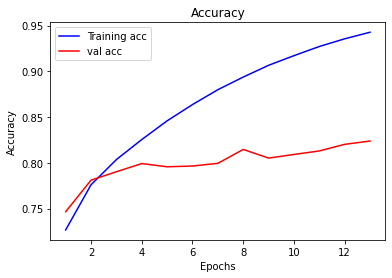

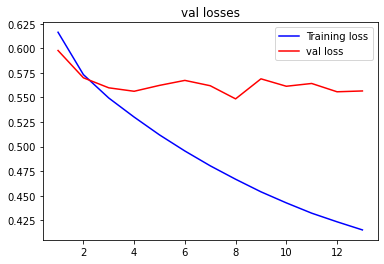

In [ ]:
import matplotlib.pylab as plt

acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(1,len(acc)+1)
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(epochs,acc,'blue',label='Training acc')
plt.plot(epochs,val_acc,'red',label='val acc')
plt.legend()

plt.figure()
plt.title('val losses')
plt.plot(epochs,loss,'blue',label='Training loss')
plt.plot(epochs,val_loss,'red',label='val loss')
plt.legend()
plt.show()

google_plot=pd.DataFrame({'acc':acc,'val acc':val_acc,'loss':loss,'val_loss':val_loss,'epochs':epochs})
google_plot.to_csv('/content/google_plot.csv')

In [ ]:
google_pred = pd.DataFrame({'0': y_pre[:, 0], '1': y_pre[:, 1]})
google_pred

,0,1
0,7.833169e-01,0.216683
1,9.556667e-01,0.044333
2,9.879216e-01,0.012078
3,9.998472e-01,0.000153
4,3.782984e-01,0.621702
...,...,...
15763,9.996454e-01,0.000355
15764,9.442886e-08,1.000000
15765,4.017415e-05,0.999960
15766,2.758281e-02,0.972417


In [ ]:
google_pred.to_csv('/content/google_pre.csv')

In [ ]:
x=pd.read_csv('/content/google_pred.csv')
x.isnull().values.sum()

0

In [ ]:
import matplotlib.pylab as plt
font = {'size'   : 22}

plt.rc('font', **font)

def plot_confusion_matrix(cm, target_names,title='Confusion matrix',cmap=None,normalize=False):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if cmap is None:
        cmap = plt.get_cmap('Blues')
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float32') / cm.sum(axis=1)
        cm = np.round(cm,2)
        

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel("Predicted label\naccuracy={:0.4f}\n misclass={:0.4f}".format(accuracy, misclass))
    plt.show()

In [ ]:
crawl_pred=pd.read_csv('/content/crawl_pred.csv')
wiki_pred=pd.read_csv('/content/wiki_pred.csv')
glove_pred=pd.read_csv('/content/glove_pred.csv')
google_pred=pd.read_csv('/content/google_pred.csv')
sub_pred=pd.read_csv('/content/subcrawl_pred.csv')

In [ ]:
y_pred_c=crawl_pred[['0','1']].values
y_pred_w=wiki_pred[['0','1']].values
y_pred_gl=glove_pred[['0','1']].values
y_pred_g=google_pred[['0','1']].values
y_pred_s=sub_pred[['0','1']].values
pred_dict={'crawl':y_pred_c,'wiki':y_pred_w,'google':y_pred_g,'glove':y_pred_gl,'sub':y_pred_s}

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


crawl
(0.8258288277978212, 0.8253166047957704, 0.8255709323102913, None)
[0.87323803 0.77790383]
0.8255709323102913
0.8385971588026383
[[8766 1262]
 [1283 4457]]


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


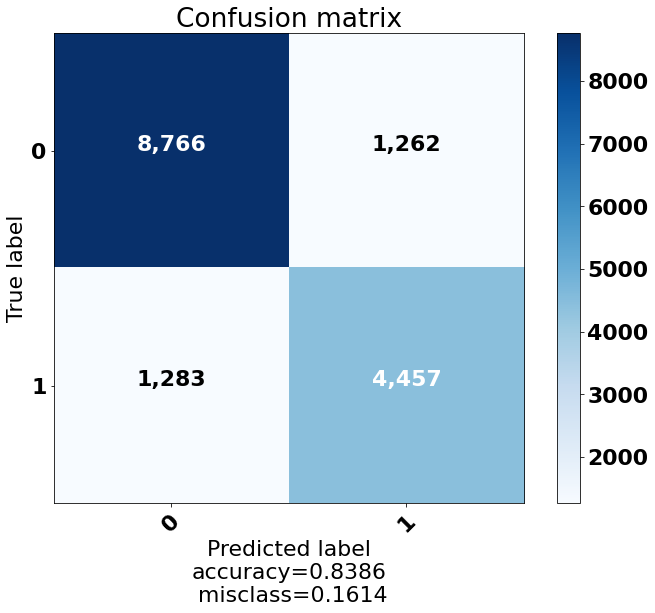

wiki
(0.8221840085494997, 0.8154306269970216, 0.8185192572277804, None)
[0.87092171 0.76611681]
0.8185192572277804
0.833650431253171
[[8849 1179]
 [1444 4296]]


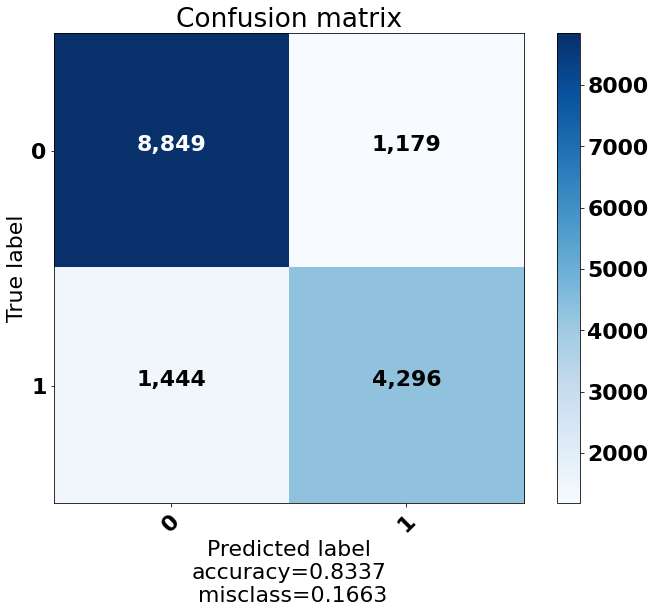

google
(0.8205415323293747, 0.8143835587880068, 0.8172193179207579, None)
[0.86975369 0.76468494]
0.8172193179207579
0.8323186199898529
[[8828 1200]
 [1444 4296]]


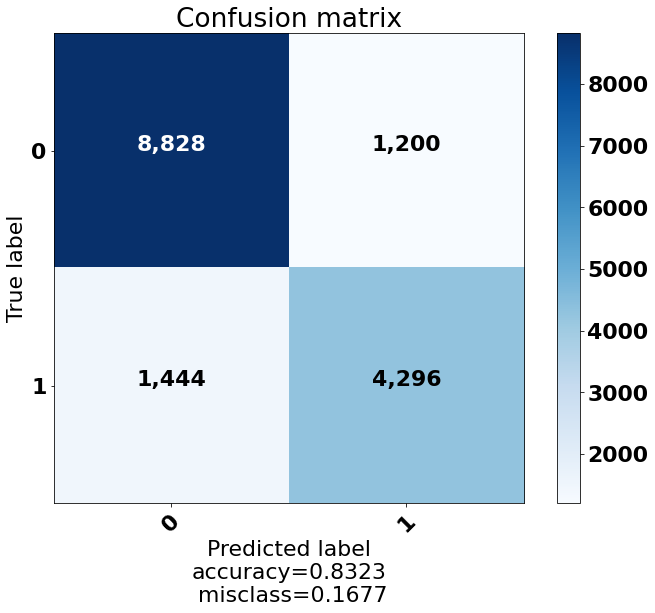

glove
(0.8184746714148141, 0.8154728085402685, 0.8169127001895158, None)
[0.86813023 0.76569517]
0.8169127001895158
0.8312404870624048
[[8759 1269]
 [1392 4348]]


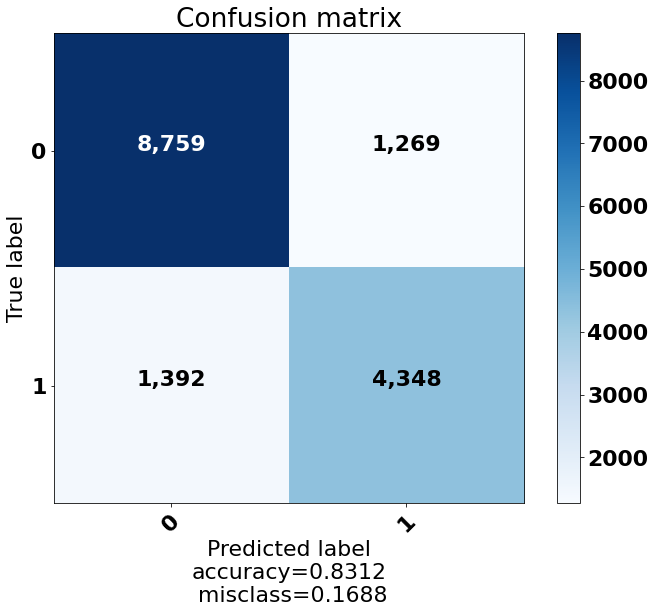

sub
(0.8228766240002194, 0.8127848644005843, 0.8172161786637981, None)
[0.87138594 0.76304642]
0.8172161786637981
0.8332699137493658
[[8906 1122]
 [1507 4233]]


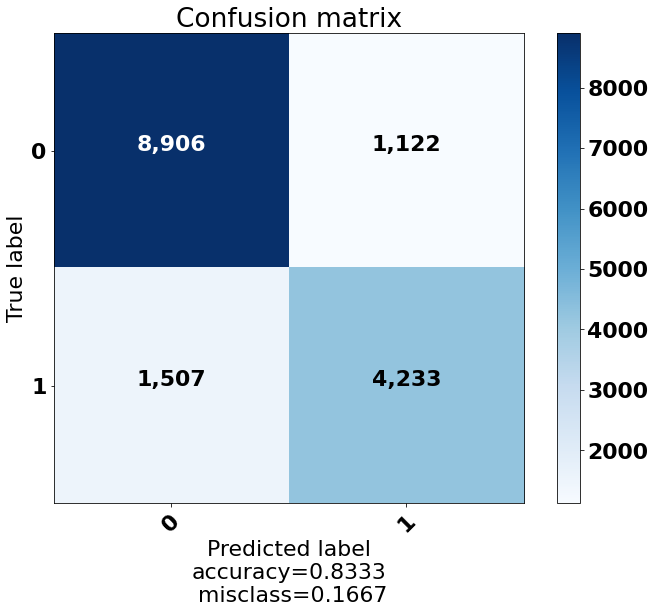

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
import itertools

for k,v in pred_dict.items():
  print(k)
  y_p=np.argmax(v,axis=1)
  print(precision_recall_fscore_support(y_test, y_p, average='macro'))
  print(f1_score(y_test, y_p, average=None))
  print(f1_score(y_test, y_p, average='macro'))
  print(accuracy_score(y_test, y_p))
  # print(precision(y_test,y_p))
  # print(recall(y_test,y_p))
  cm=confusion_matrix(y_test,y_p)
  print(confusion_matrix(y_test,y_p))
  plot_confusion_matrix(cm, normalize=False, target_names=['0','1'])



(0.8531522273667926, 0.8410519882308629, 0.8463400662261524, None)
[0.89221001 0.80047012]
0.8600329781836631


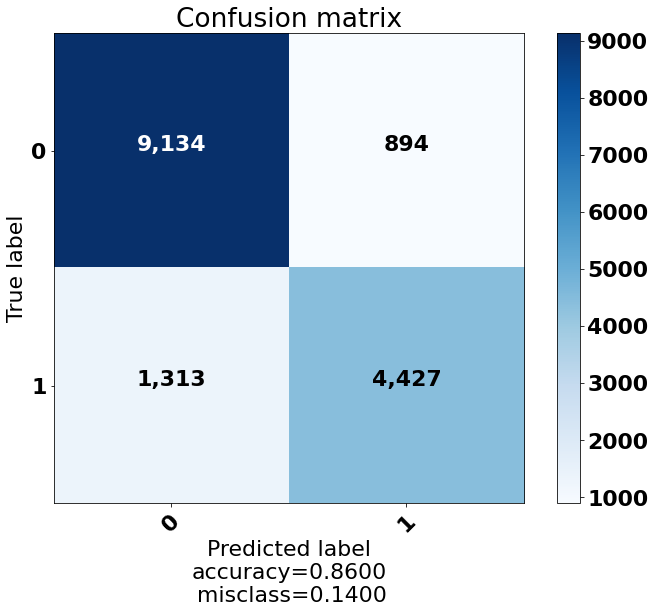

In [ ]:
y_p=0.25*y_pred_c+0.25*y_pred_s+0.25*y_pred_w+0.25*y_pred_g
# y_p=0.34*y_pred_c+0.33*y_pred_s+0.33*y_pred_w
y_p=np.argmax(y_p,axis=1)
print(precision_recall_fscore_support(y_test, y_p, average='macro'))
print(f1_score(y_test, y_p, average=None))
print(accuracy_score(y_test, y_p))
# print(precision(y_test,y_p))
# print(recall(y_test,y_p))
cm=(confusion_matrix(y_test,y_p))
plot_confusion_matrix(cm, normalize=False, target_names=['0','1'])


In [ ]:
# y_p=0.35*y_pred_c+0.15*y_pred+0.35*y_pred_w+0.15*y_pred_gl
y_p=0.33*y_pred+0.33*y_predg+0.34*y_pre
y_p=np.argmax(y_p,axis=1)
y_t=np.argmax(y_test,axis=1)

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_t, y_p, average=None)

array([0.88411975, 0.79419014])

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_t, y_p)

0.8517250126839168

In [ ]:
y_pred

array([[0.72091556, 0.2790844 ],
       [0.8970958 , 0.10290424],
       [0.8834689 , 0.11653106],
       ...,
       [0.15851144, 0.84148854],
       [0.11503624, 0.8849638 ],
       [0.8834633 , 0.11653667]], dtype=float32)

In [ ]:
y_pred_c

array([[0.77645546, 0.22354454],
       [0.8485904 , 0.15140961],
       [0.6735433 , 0.32645673],
       ...,
       [0.1117273 , 0.88827264],
       [0.10367561, 0.89632434],
       [0.8723563 , 0.12764369]])

In [ ]:
y_p=0.25*y_pred_c+0.25*y_pred_s+0.25*y_pred_w+0.25*y_pred_g
comb_pred = pd.DataFrame({'0': y_p[:, 0], '1': y_p[:, 1]})
comb_pred.to_csv('/content/comb_pred.csv')

In [ ]:
comb_pred

,0,1
0,0.579083,0.420917
1,0.874921,0.125079
2,0.792299,0.207701
3,0.861314,0.138686
4,0.729770,0.270230
...,...,...
15763,0.880833,0.119167
15764,0.117397,0.882603
15765,0.126518,0.873481
15766,0.163163,0.836837
